<a href="https://colab.research.google.com/github/mtsilimos/ETH/blob/main/CV_BESTMODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKTOQ5L/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKTOQ5L/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
def load_image_train(datapoint):
    input_image = tf.image.resize_with_pad(datapoint['image'], 128, 128)
    input_mask = tf.image.resize_with_pad(datapoint['segmentation_mask'], 128, 128)

    # Randomly choosing the images to flip right left.
    # We need to split both the input image and the input mask as the mask is in correspondence to the input image.
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # Normalizing the input image.
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # Returning the input_image and the input_mask
    return input_image, input_mask


In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize_with_pad(datapoint['image'], 128, 128)
    input_mask = tf.image.resize_with_pad(datapoint['segmentation_mask'], 128, 128)

    # Normalizing the input image.
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [30]:
import tensorflow as tf
train_images = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(32)

test_images = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(32)





In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation,\
                                    BatchNormalization, Dropout, MaxPooling2D,\
                                    Conv2D, concatenate, Conv2DTranspose
# Unet inspired model
# for the original see @https://arxiv.org/abs/1505.04597
#
# the detailed aspect of the layers is done on purpose, in order to capture
# the architecture of Unet
# 4 levels of encoder/decoder and batchnorm after each conv layer (except last)
BASE_FILTERS = 32
INPUT_SIZE   = (128, 128, 3)
DROPOUT      = 0.4
ACTIVATION   = 'relu'
INITIALIZER  = 'he_normal'

input_layer = Input(INPUT_SIZE)

c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (input_layer)
c1 = BatchNormalization()(c1)
c1 = Dropout(DROPOUT)(c1)
c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(DROPOUT)(c2)
c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(DROPOUT)(c3)
c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(DROPOUT)(c4)
c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(DROPOUT)(c5)
c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(BASE_FILTERS * 8, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(DROPOUT)(c6)
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(BASE_FILTERS * 4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(DROPOUT)(c7)
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(BASE_FILTERS * 2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(DROPOUT)(c8)
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(BASE_FILTERS, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(DROPOUT)(c9)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c9)

# in the case where predictions concerns several classes, you will have to
# adjust the ouput with the number of classes to be predicted and change the
# activation function



# eg. ouput_layer = Conv2D(NUMBER_OF_CLASSES, (1, 1), activation='softmax')(c9)
ouput_layer = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

model = Model(inputs=[input_layer], outputs=[ouput_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])


In [25]:
history = model.fit(train_images, epochs=3, validation_data=test_images)

Epoch 1/3
115/115 [==============================] - 50s 327ms/step - loss: -3201.9573 - accuracy: 0.3227 - val_loss: -3208.0984 - val_accuracy: 0.0774
Epoch 2/3
115/115 [==============================] - 40s 330ms/step - loss: -5048.1406 - accuracy: 0.3070 - val_loss: -6193.9604 - val_accuracy: 0.2689
Epoch 3/3
115/115 [==============================] - 49s 409ms/step - loss: -7789.6836 - accuracy: 0.2980 - val_loss: -9685.7822 - val_accuracy: 0.3171


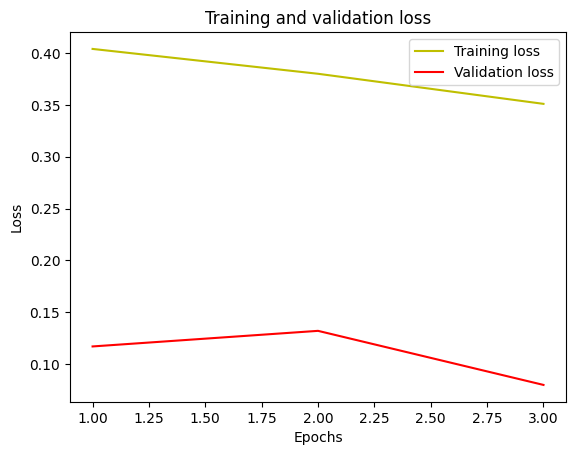

In [13]:
from matplotlib import pyplot as plt
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


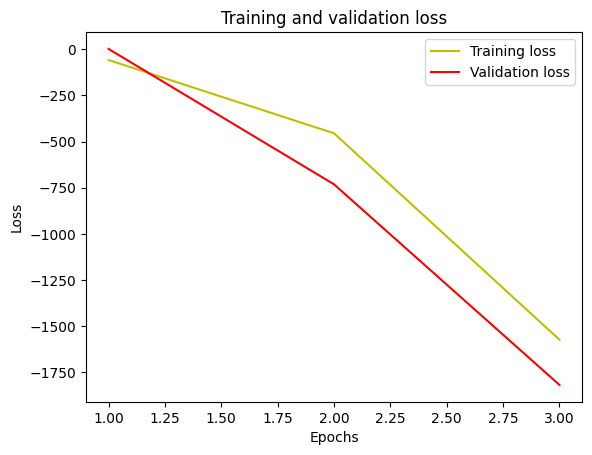

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
val_preds = model.predict(test_images)

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()






115/115 [==============================] - 12s 98ms/step


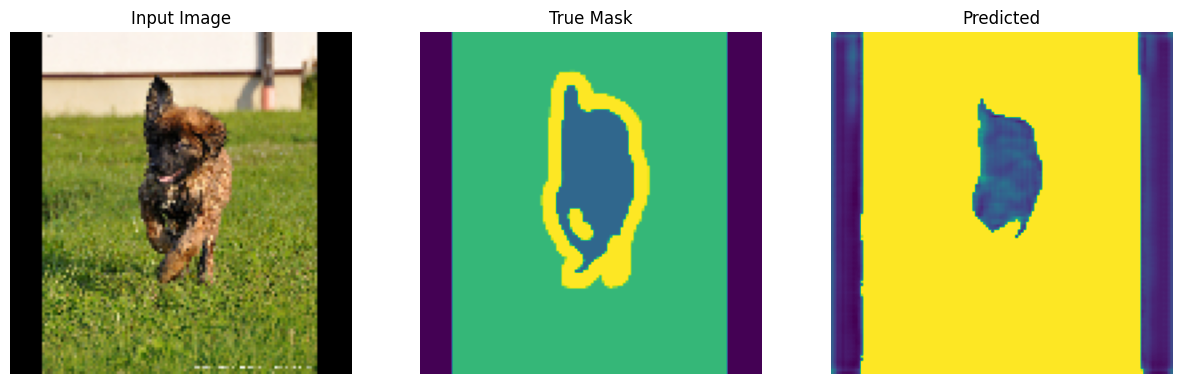

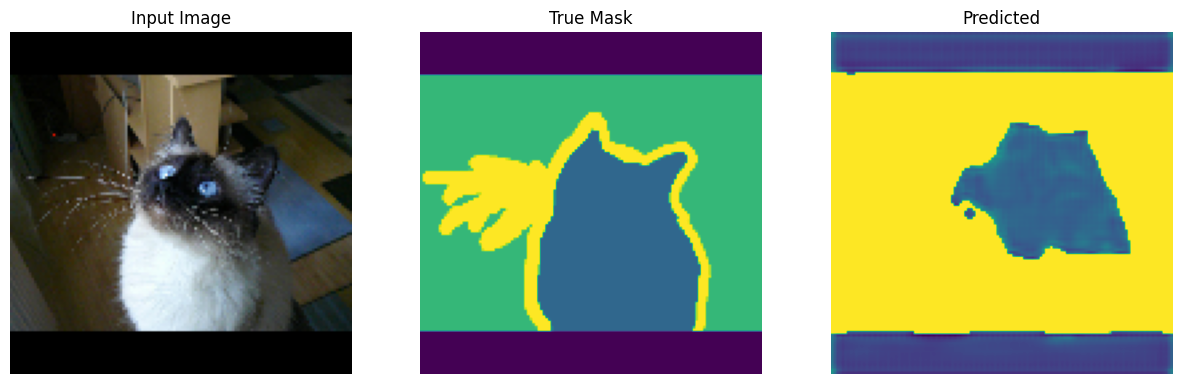

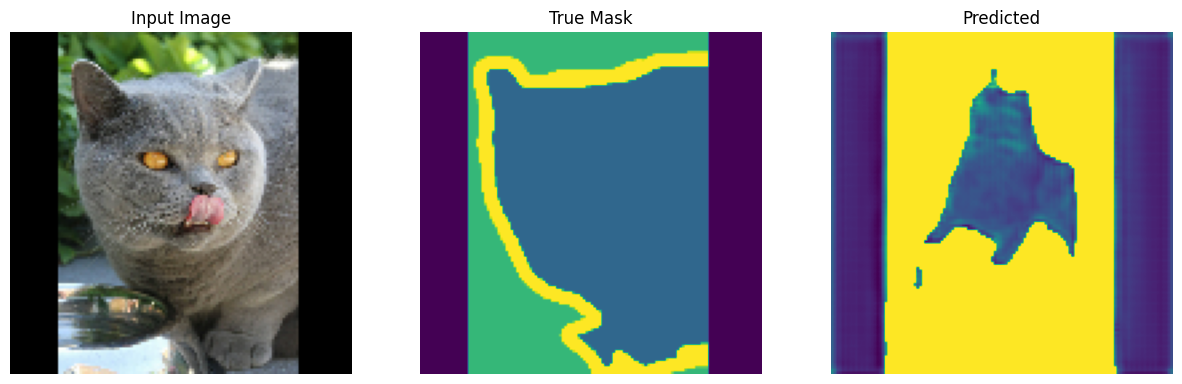

In [96]:
a=0
for images, masks in test_images.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask,val_preds[a]])
  a=a+1

In [50]:
from keras.layers import Input

from keras.models import Model, load_model
from keras.layers import Input



from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose,MaxPooling2D, concatenate,UpSampling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.losses import BinaryCrossentropy
import random

import tensorflow as tf

inputs = Input((128, 128, 3))



c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)

c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)

c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)

c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)

c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_135 (Conv2D)         (None, 128, 128, 16)         448       ['input_9[0][0]']             
                                                                                                  
 conv2d_136 (Conv2D)         (None, 128, 128, 16)         2320      ['conv2d_135[0][0]']          
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 64, 64, 16)           0         ['conv2d_136[0][0]']          
 ng2D)                                                                                      

In [97]:
from tensorflow.keras.datasets import mnist

In [99]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step
